# Генерация мел-спектрограмм с использованием рекурентного GRU автоэнкодера на примере музыки Бетховена — BeetNet

##Постановка задачи

Цель работы — создание автоэнкодера для генерации реалистичных спектрограмм, соответствующих аудиозаписям фортепианных произведений Бетховена.

##Data mining and preparation

Basic imports.

In [ ]:
!pip install -q torchcodec

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 44.4 MB/s eta 0:00:00


In [ ]:
import os
import torch
import torchaudio
import pandas as pd
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
from pathlib import Path

Choosing the device.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

A library used to load datasets from Kaggle.

In [ ]:
import kagglehub

kagglehub.dataset_download("alonhaviv/musicnet")

100%|██████████| 10.8G/10.8G [02:21<00:00, 82.0MB/s]

Extracting files...


'/root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2'

Saving Kaggle's token in the directory that opendatasets operates with.

In [ ]:
from google.colab import files
import os

uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
home = Path('/root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2')
DIR = home / 'musicnet'
os.listdir(DIR)

['train_labels', 'test_labels', 'train_data', 'test_data']

Choosing only Beethoven's piano ids.

In [ ]:
df = pd.read_csv(home / 'musicnet_metadata.csv')
df.head()
bh = df[(df['composer'] == 'Beethoven') & (df['ensemble'] == 'Solo Piano')]
bh['id'].to_csv(DIR / 'ids.csv', index=False)

Deleting unnecessary files. Leaving only 92 needed.

In [ ]:
df = pd.read_csv(DIR / 'ids.csv')
directory = DIR / 'train_data'
os.listdir(directory)

['1755.wav',
 '1790.wav',
 '1859.wav',
 '2335.wav',
 '2155.wav',
 '2374.wav',
 '2364.wav',
 '2220.wav',
 '2334.wav',
 '1873.wav',
 '2530.wav',
 '2207.wav',
 '1776.wav',
 '1792.wav',
 '2159.wav',
 '2346.wav',
 '2198.wav',
 '2618.wav',
 '2358.wav',
 '2127.wav',
 '2307.wav',
 '2595.wav',
 '1791.wav',
 '2521.wav',
 '2293.wav',
 '2304.wav',
 '2431.wav',
 '2586.wav',
 '1835.wav',
 '2248.wav',
 '2463.wav',
 '2540.wav',
 '2105.wav',
 '2678.wav',
 '1733.wav',
 '2397.wav',
 '2502.wav',
 '2477.wav',
 '2594.wav',
 '2342.wav',
 '2200.wav',
 '2222.wav',
 '2359.wav',
 '2224.wav',
 '2294.wav',
 '2156.wav',
 '2348.wav',
 '2622.wav',
 '2444.wav',
 '2522.wav',
 '2186.wav',
 '2081.wav',
 '2318.wav',
 '2138.wav',
 '2195.wav',
 '2217.wav',
 '1760.wav',
 '2308.wav',
 '2542.wav',
 '2218.wav',
 '2611.wav',
 '2497.wav',
 '2201.wav',
 '1749.wav',
 '2313.wav',
 '1793.wav',
 '1872.wav',
 '1765.wav',
 '1813.wav',
 '2614.wav',
 '1822.wav',
 '2568.wav',
 '2148.wav',
 '2284.wav',
 '2319.wav',
 '2487.wav',
 '2619.wav',

In [ ]:
files_in_df = set(df['id'].astype(str) + '.wav')
files_in_directory = set(os.listdir(directory))
files_to_delete = files_in_directory - files_in_df

for filename in files_to_delete:
    file_path = directory / filename
    os.remove(file_path)
    print(f'Deleted: {file_path}')

Loading and resampling the chosen files to 16000 Hz. Saving 2-second samples to `\beethoven`.


In [ ]:
def extract_segments(file_path, idx, segment_length=2):
    waveform, sr = torchaudio.load(file_path)
    resample = torchaudio.transforms.Resample(orig_freq=sr, new_freq=16000)
    waveform = resample(waveform)
    sr = 16000
    total_length = waveform.size(1) / sr

    num_segments = int(total_length // segment_length) + 1
    segment_start_times = np.random.uniform(0, total_length - segment_length, num_segments)

    output_dir = DIR / 'beethoven'
    os.makedirs(output_dir, exist_ok=True)

    for i, start_time in enumerate(segment_start_times):
        start_sample = int(start_time * sr)
        end_sample = start_sample + int(segment_length * sr)
        segment = waveform[:, start_sample:end_sample]
        output_file = output_dir / f'{idx}_{i}.wav'
        torchaudio.save(output_file, segment, sr)

    os.remove(file_path)


for file in tqdm(files_in_directory):
    idx = int(file.split('.')[0])
    extract_segments(directory / file, idx)

  0%|          | 0/92 [00:00<?, ?it/s]

In [ ]:
bth = DIR / 'beethoven'
print(os.listdir(DIR))

['train_labels', 'test_labels', 'train_data', 'test_data', 'beethoven', 'ids.csv']



#Kaggle

Load your token.

In [ ]:
from google.colab import files

uploaded = files.upload('/root/.config/kaggle')

Saving kaggle.json to /root/.config/kaggle/kaggle.json



Send the dataset to Kaggle.

In [ ]:
!kaggle datasets init -p /root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2/musicnet/beethoven

Data package template written to: /root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2/musicnet/beethoven/dataset-metadata.json



Write the `dataset-metadata.json` file.


In [ ]:
import json

data = {
  "title": "BeethovenNet Samples",
  "id": "alexzyukov/beethoven",
  "description": "This dataset contains segments of Beethoven's music, extracted for analysis and research purposes.",
  "licenses": [
    {
      "name": "GPL-3.0",
      "url": "https://opensource.org/licenses/GPL-3.0"
    }
  ],
  "keywords": ["Beethoven", "Music"]
}

file_path = '/root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2/musicnet/beethoven/dataset-metadata.json'

with open(file_path, 'w') as json_file:
    json.dump(data, json_file, indent=2)

In [ ]:
os.remove(file_path)

Compressing the files into one zip.

In [ ]:
import os
import zipfile

def zip_folder(folder_path, output_zip_file):
    with zipfile.ZipFile(output_zip_file, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for file in os.listdir(folder_path):
            file_path = os.path.join(folder_path, file)
            if os.path.isfile(file_path):
                zipf.write(file_path, file)
                os.remove(file_path)

folder_to_zip = bth
output_zip = DIR / 'segments.zip'

zip_folder(folder_to_zip, output_zip)

Estimating the size of the dataset in MB.

In [ ]:
os.path.getsize(output_zip) / (1024 * 1024)

971.9629230499268

In [ ]:
import shutil

shutil.move(output_zip, bth)

'/root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2/musicnet/beethoven/segments.zip'

Contributing to Kaggle.

In [ ]:
!kaggle datasets create -p /root/.cache/kagglehub/datasets/alonhaviv/musicnet/versions/2/musicnet/beethoven/

Starting upload for file segments.zip
100% 972M/972M [00:10<00:00, 93.5MB/s]
Upload successful: segments.zip (972MB)
User cancelled operation


#BeetNet

Установим и импортируем основные библиотеки для анализа данных, разработки нейросетей и работы с аудио.

In [1]:
!pip install -q opendatasets torchcodec torchinfo

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 51.8 MB/s eta 0:00:00


In [2]:
import os
from pathlib import Path
import time
import json

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.notebook import tqdm

import torch
import torchaudio
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid, save_image

from torchaudio.transforms import InverseMelScale, GriffinLim
import soundfile as sf


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
torch.manual_seed(42)
np.random.seed(42)


cuda


Используем токен `Kaggle`.

In [3]:
from google.colab import files
import os

uploaded = files.upload()

Saving kaggle.json to kaggle.json


Скачаем датасет.

In [4]:
import opendatasets as od

url = 'https://www.kaggle.com/datasets/alexzyukov/beethoven'
od.download(url)

Dataset URL: https://www.kaggle.com/datasets/alexzyukov/beethoven


100%|██████████| 973M/973M [00:08<00:00, 125MB/s]


##Исследование данных

Подсчитаем количество доступных для анализа файлов.

In [5]:
from pathlib import Path

DIR = Path('./beethoven')

Имеется 18941 файл.

In [6]:
file_names = os.listdir(DIR)
file_names.remove('dataset-metadata.json')
len(file_names)

18941

Получим основные характеристики файлов.

In [7]:
def get_audio_duration(path):
    waveform, sr = torchaudio.load(str(path))
    num_samples = waveform.shape[-1]
    duration = num_samples / sr
    return duration, sr

In [8]:
rows = []

for p in tqdm(file_names):
    file_path = DIR / p
    dur, sr = get_audio_duration(file_path)
    rows.append((file_path, dur, sr, os.path.getsize(file_path)))

df = pd.DataFrame(rows, columns=['file_path', 'duration_seconds', 'sr','size'])
df.head()

  0%|          | 0/18941 [00:00<?, ?it/s]

,file_path,duration_seconds,sr,size
0,beethoven/2614_127.wav,2.0,16000,64078
1,beethoven/2510_33.wav,2.0,16000,64078
2,beethoven/2528_16.wav,2.0,16000,64078
3,beethoven/2576_0.wav,2.0,16000,64078
4,beethoven/2576_46.wav,2.0,16000,64078


Датасет собран так, что все аудиофрагменты (18941 штук) длиной строго 2 секунды, с частотой дискретизации 16к Гц, одноканальные. Дополнительная обработка или учет прочих случаев не требуется.

Построим пример спектрограммы. Возьмём случайный аудиофайл, усредним значения по аудиоканалам. Трансформируем в спектрограмму. Затем преобразуем амплитудные значения в громкость в децибелах.

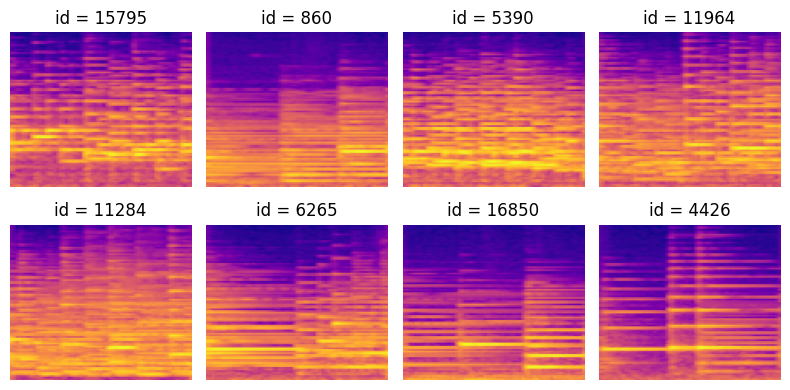

In [9]:
plt.figure(figsize=(8, 4))

for i, idx in enumerate(np.random.randint(0, df.shape[0], 8)):
    sample = df.iloc[idx]
    output, sr = torchaudio.load(sample['file_path'])

    transformations = [
        torchaudio.transforms.MelSpectrogram(sr, n_fft=2048, hop_length=512, n_mels=96),
        torchaudio.transforms.AmplitudeToDB()
    ]

    for transform in transformations:
        output = transform(output)

    plt.subplot(2, 4, i + 1)
    plt.imshow(output[0].numpy(), origin='lower', aspect='auto', cmap='plasma')
    plt.title(f'id = {idx}')
    plt.axis('off')

plt.tight_layout()
plt.show()

Параметры преобразования всех доступных аудио из датасета в спектрограммы.

In [10]:
TARGET_SR = 16000
TARGET_LEN = TARGET_SR * 2
N_FFT = 2048
HOP_LENGTH = 512
N_MELS = 96
DATA_DIR = Path("beethoven")
MEL_CACHE = Path("mel_cache")
MEL_CACHE.mkdir(exist_ok=True)

Имена аудиофайлов в формате `Path`.

In [11]:
file_names = [Path(file) for file in file_names]

Преобразование аудио в мел-спектрограмму, а затем пересчет амплитуд в дБ.

In [12]:
mel_spec = torchaudio.transforms.MelSpectrogram(
    sample_rate=TARGET_SR,
    n_fft=N_FFT,
    hop_length=HOP_LENGTH,
    n_mels=N_MELS,
    power=1.0
)
db_transform = torchaudio.transforms.AmplitudeToDB(
    stype='amplitude'
)

Сделаем `clip` для аудио.

In [13]:
DB_MIN = -40.0
DB_MAX = 60.0

Получим спектрограммы для всех аудио. Исключаем файлы без звука из выборки для стабильности обучения.

In [14]:
mel_paths = []

for p in tqdm(file_names, desc="Precompute mel"):
    out_path = MEL_CACHE / (p.stem + ".pt")

    if out_path.exists():
        continue

    wav, sr = torchaudio.load(str(DATA_DIR / p))

    if wav.abs().mean() < 1e-3:
        print(p, end=' ')
        continue

    wav = wav / wav.abs().max()

    with torch.no_grad():
        mel = mel_spec(wav)
        mel_db = db_transform(mel)

    mel_db = torch.clamp(mel_db, DB_MIN, DB_MAX)
    torch.save(mel_db.squeeze(0).cpu(), out_path)
    mel_paths.append(out_path)

Precompute mel:   0%|          | 0/18941 [00:00<?, ?it/s]

2576_46.wav 2581_4.wav 2590_12.wav 2423_134.wav 2632_123.wav 2348_147.wav 2477_48.wav 2411_61.wav 2325_20.wav 2346_134.wav 2325_77.wav 2581_58.wav 2576_49.wav 2564_89.wav 2581_119.wav 2608_17.wav 2423_19.wav 2516_132.wav 2564_47.wav 2345_101.wav 2359_54.wav 2490_137.wav 2358_7.wav 2345_203.wav 2581_133.wav 2477_31.wav 2567_35.wav 2373_124.wav 2487_22.wav 2423_9.wav 2472_6.wav 2322_150.wav 2530_95.wav 2509_172.wav 2607_74.wav 2359_63.wav 2487_74.wav 2555_51.wav 2348_220.wav 2591_11.wav 2591_39.wav 2492_208.wav 2486_110.wav 2540_13.wav 2477_5.wav 2614_57.wav 2364_49.wav 2422_117.wav 2633_2.wav 2591_64.wav 2594_84.wav 2677_16.wav 2555_5.wav 2620_7.wav 2346_97.wav 2490_143.wav 2593_215.wav 2358_10.wav 2490_119.wav 2477_86.wav 2391_99.wav 2575_3.wav 2618_57.wav 2595_88.wav 2540_89.wav 2393_68.wav 2487_24.wav 2677_81.wav 2528_159.wav 2564_217.wav 2633_55.wav 2611_279.wav 2343_121.wav 2322_66.wav 2443_240.wav 2348_87.wav 2373_90.wav 2443_219.wav 2487_43.wav 2509_138.wav 2567_71.wav 2512_208.w

Проверяем, сохранились ли спектрограммы.

In [15]:
len(os.listdir(MEL_CACHE))

18825

In [16]:
len(mel_paths)

18825

###Данные для обучения и параметры

Мел-спектрограммы сохранены в `mel_cache/*.pt`.

In [17]:
mel_files = sorted(mel_paths)
sample_mel = torch.load(str(mel_files[0]))
N_MELS = sample_mel.shape[0]
SEQ_LEN = sample_mel.shape[1]

In [18]:
N_MELS, SEQ_LEN

(96, 63)

Получим информацию о громкости всех аудио в дБ, построим гистограммы и определим разумные пределы громкостей.

In [19]:
values = []

for p in tqdm(mel_files):
    mel = torch.load(p).float()
    values.append(mel.reshape(-1))

values = torch.cat(values)
values_np = values.cpu().numpy()

  0%|          | 0/18825 [00:00<?, ?it/s]

Вычислим основные статистики для дальнейшей стандартизации данных.

In [20]:
min_amp = values_np.min()
max_amp = values_np.max()
mean_amp = values_np.mean()
std_amp = values_np.std()

print("min =", min_amp)
print("max =", max_amp)
print("mean =", mean_amp)
print("std =", std_amp)

min = -40.0
max = 59.544
mean = 8.37063
std = 16.936071


Строим гистограмму громкостей в дБ.

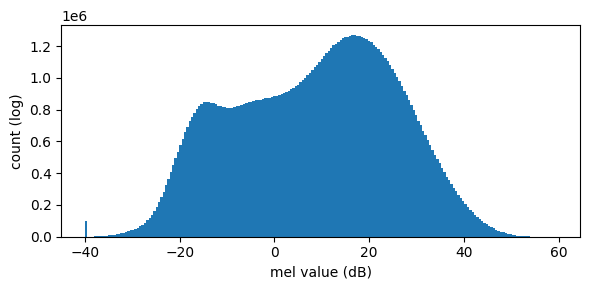

In [21]:
plt.figure(figsize=(6, 3))
plt.hist(values_np, bins=200)
plt.xlabel("mel value (dB)")
plt.ylabel("count")
plt.tight_layout()
plt.show()

Датасет со стандартизацией.

In [22]:
class MelDataset(Dataset):
    def __init__(self, files):
        self.files = files

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        mel = torch.load(str(self.files[idx])).float()
        mel = torch.clamp(mel, min_amp, max_amp)
        mel = (mel - mean_amp) / std_amp
        return mel

dataset = MelDataset(mel_files)
batch_size = 32
loader = DataLoader(
    dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
    num_workers=2
)

###Рекурентный автоэнкодер с GRU для спектрограмм

Автоэнкодер состоит из энкодера и декодера и работает с мел-спектрограммами формы `(n_mels, time)`, рассматривая их как временные последовательности спектральных кадров.


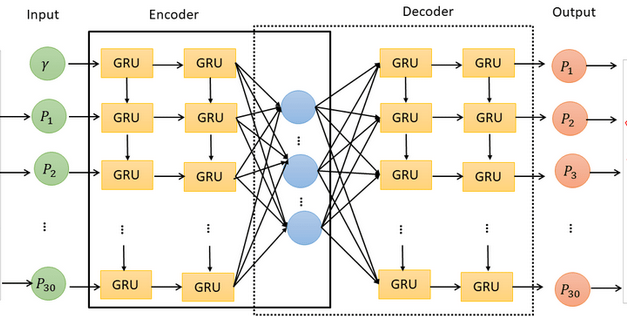

Зададим параметры энкодера и декодера.

In [23]:
latent_dim = 256
enc_hidden = 256
dec_hidden = 256

**Энкодер** принимает на вход мел-спектрограмму и интерпретирует её как последовательность временных шагов, где каждый шаг представляет собой вектор частотных коэффициентов размерности `n_mels`. На каждом временном шаге выполняется линейная проекция частотного вектора в скрытое пространство, после чего вся последовательность обрабатывается рекуррентной сетью `GRU`. Скрытое состояние на последнем временном шаге используется в качестве латентного представления `z`, кодирующего целый аудиофрагмент.


In [24]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin_in = nn.Linear(N_MELS, enc_hidden)
        self.gru = nn.GRU(
            input_size=enc_hidden,
            hidden_size=latent_dim,
            num_layers=2,
            batch_first=True,
            bidirectional=False
        )
    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = self.lin_in(x)
        out, h = self.gru(x)
        z = out[:, -1, :]
        return z

**Декодер** получает латентный вектор $z$ и разворачивает его во временную последовательность фиксированной длины. Для этого латент сначала проецируется в скрытое пространство декодера и затем повторяется для каждого временного шага. Полученная последовательность подаётся на вход `GRU`, которая генерирует временную динамику спектрограммы, условленную латентным кодом. На каждом временном шаге выход `GRU` линейно преобразуется в вектор размерности `n_mels`, формируя восстановленную мел-спектрограмму.


In [25]:
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin_proj = nn.Linear(latent_dim, dec_hidden)
        self.gru = nn.GRU(
            input_size=dec_hidden,
            hidden_size=dec_hidden,
            num_layers=2,
            batch_first=True,
            bidirectional=False
        )
        self.out = nn.Linear(dec_hidden, N_MELS)
    def forward(self, z):
        b = z.size(0)
        t = SEQ_LEN
        h0 = self.lin_proj(z)
        h0 = h0.unsqueeze(1).repeat(1, t, 1)
        out, _ = self.gru(h0)
        out = self.out(out)
        out = out.permute(0, 2, 1)
        return out

Объединим модели в автоэнкодер.

In [26]:
class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()
    def forward(self, x):
        z = self.enc(x)
        rec = self.dec(z)
        return rec

In [27]:
autoencoder = Autoencoder().to(device)

###Оптимизация

Используем `Adam`. Наилучший результат даёт использование $lr=10^{-3}$.

In [28]:
optimizer = optim.Adam(autoencoder.parameters(), lr=1e-3, betas=(0.5, 0.999))

In [29]:
history = {'recon_l1': []}

###Цикл обучения

Обучаем автоэнкодер на заранее сохранённых мел-спектрограммах.

In [43]:
n_epochs = 10
autoencoder.train()
for epoch in range(n_epochs):
    epoch_loss = 0.0
    count = 0
    for i, batch in enumerate(loader):
        batch = batch.to(device)
        optimizer.zero_grad()
        rec = autoencoder(batch)
        loss = F.l1_loss(rec, batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(autoencoder.parameters(), 1.0)
        optimizer.step()
        epoch_loss += loss.item()
        count += 1
    avg = epoch_loss / max(count,1)
    history['recon_l1'].append(avg)
    torch.save(autoencoder.state_dict(), f'ae_epoch_{epoch+1}.pth')
    print(f"Epoch {epoch+1}/{n_epochs}  Recon_L1={avg:.6f}")

Epoch 1/10  Recon_L1=0.175622
Epoch 2/10  Recon_L1=0.174878
Epoch 3/10  Recon_L1=0.174028
Epoch 4/10  Recon_L1=0.173533
Epoch 5/10  Recon_L1=0.172883
Epoch 6/10  Recon_L1=0.171984
Epoch 7/10  Recon_L1=0.171448
Epoch 8/10  Recon_L1=0.170782
Epoch 9/10  Recon_L1=0.170480
Epoch 10/10  Recon_L1=0.169796


Построим график потерь во время обучения. Полученный график показывает высокую стабильность.

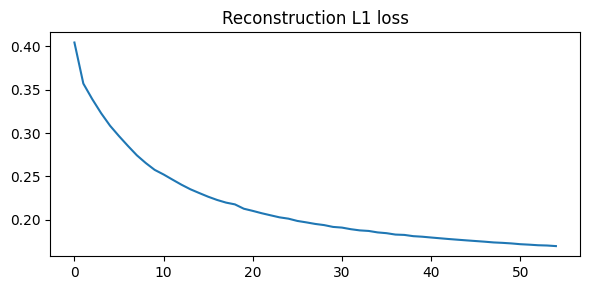

In [44]:
plt.figure(figsize=(6,3))
plt.plot(history['recon_l1'])
plt.title('Reconstruction L1 loss')
plt.tight_layout()
plt.show()

###Тестирование

Возьмём случайное изображение из обучающей выборки, получим закодированное представление, сгенерируем на его основе спектрограмму. Сравним оригинал и генерацию.

In [55]:
def denorm_mel_db(mel_tensor):
    m = mel_tensor.cpu() * std_amp + mean_amp
    m = torch.clamp(m, min_amp, max_amp)
    return m

autoencoder.eval()
idx = np.random.randint(0, len(mel_files)-1)
real_raw = torch.load(mel_files[idx]).float()
real_clipped = torch.clamp(real_raw, min_amp, max_amp)
real_norm = (real_clipped - mean_amp) / std_amp

with torch.no_grad():
    inp = real_norm.unsqueeze(0).to(device)
    rec = autoencoder(inp).squeeze(0).cpu()

Строим графики реальной спектрограммы, реконструкции и разницы между ними.

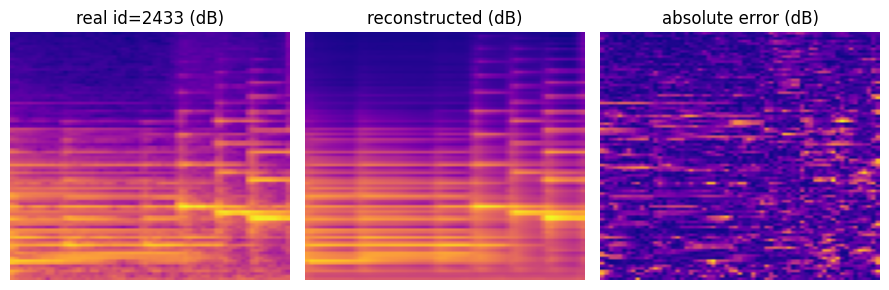

In [71]:
plt.figure(figsize=(9, 3))

plt.subplot(1,3,1)
plt.imshow(denorm_mel_db(real_norm).numpy(), origin='lower', aspect='auto', cmap='plasma')
plt.title(f"real id={idx} (dB)")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(denorm_mel_db(rec).numpy(), origin='lower', aspect='auto', cmap='plasma')
plt.title("reconstructed (dB)")
plt.axis('off')

plt.subplot(1,3,3)
diff = denorm_mel_db((real_norm - rec).abs())
plt.imshow(diff.numpy(), origin='lower', aspect='auto', cmap='plasma')
plt.title("absolute error (dB)")
plt.axis('off')

plt.tight_layout()
plt.show()